In [1]:
import os
import findspark

os.environ["SPARK_HOME"] = "C:\spark"
findspark.init()

# To display scroll:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master('local[*]').appName("Week2").getOrCreate()

spark

In [4]:
path=os.path.abspath('C:\\Users\\Pichau\\Downloads\\dataset_transformado_parquet')

In [5]:
df = spark.read.parquet(path)

In [6]:
df.show(5)

+--------------------+-----+----------+---------+---------+--------------------+-------+------+------------+------------+-----------+----+------------+------------+----------+----+-----+------+
|                  id|andar|area_total|area_util|banheiros|     caracteristicas|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|      bairro|        zona|condominio|iptu| tipo| valor|
+--------------------+-----+----------+---------+---------+--------------------+-------+------+------------+------------+-----------+----+------------+------------+----------+----+-----+------+
|03a386b6-7ab8-4ef...|    0|        43|       43|        1|[Churrasqueira, A...|      2|  null|       Usado| Apartamento|Residencial|   1|    Realengo|  Zona Oeste|       285|null|Venda| 22999|
|1fe78d41-b8e0-4d2...|    0|        44|       44|        1|                  []|      2|     0|       Usado| Apartamento|Residencial|   0|       Irajá|  Zona Norte|       170|   0|Venda|110000|
|1fa1c1e5-e98c-433...|    4|  

In [7]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- andar: long (nullable = true)
 |-- area_total: string (nullable = true)
 |-- area_util: string (nullable = true)
 |-- banheiros: long (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- quartos: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- tipo_anuncio: string (nullable = true)
 |-- tipo_unidade: string (nullable = true)
 |-- tipo_uso: string (nullable = true)
 |-- vaga: long (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: string (nullable = true)
 |-- iptu: string (nullable = true)
 |-- tipo: string (nullable = true)
 |-- valor: string (nullable = true)



In [35]:
df.count()

66562

# Feature selection
## Select only columns with > 1 distinct value

In [12]:
df = df.drop('id')

In [10]:
import pyspark.sql.functions as f

In [18]:
distinct_values_count = df.select(
    *[f.countDistinct(f.col(colName)).alias(colName) for colName in df.columns]
)

In [19]:
distinct_values_count.show()

+-----+----------+---------+---------+---------------+-------+------+------------+------------+--------+----+------+----+----------+----+----+-----+
|andar|area_total|area_util|banheiros|caracteristicas|quartos|suites|tipo_anuncio|tipo_unidade|tipo_uso|vaga|bairro|zona|condominio|iptu|tipo|valor|
+-----+----------+---------+---------+---------------+-------+------+------------+------------+--------+----+------+----+----------+----+----+-----+
|   53|       695|      592|       18|           6975|     14|    13|           1|           1|       1|  41|   154|   5|      3349|5118|   1| 9753|
+-----+----------+---------+---------+---------------+-------+------+------------+------------+--------+----+------+----+----------+----+----+-----+



In [31]:
columnsToDrop = [col for col,total in distinct_values_count.first().asDict().items() if total == 1]

In [33]:
df_filtered = df.drop(*columnsToDrop)

In [38]:
df_filtered.show(5)

+-----+----------+---------+---------+--------------------+-------+------+----+------------+------------+----------+----+------+
|andar|area_total|area_util|banheiros|     caracteristicas|quartos|suites|vaga|      bairro|        zona|condominio|iptu| valor|
+-----+----------+---------+---------+--------------------+-------+------+----+------------+------------+----------+----+------+
|    0|        43|       43|        1|[Churrasqueira, A...|      2|  null|   1|    Realengo|  Zona Oeste|       285|null| 22999|
|    0|        44|       44|        1|                  []|      2|     0|   0|       Irajá|  Zona Norte|       170|   0|110000|
|    4|      null|       55|        1|                  []|      2|     0|   1|      Cosmos|  Zona Oeste|      null|null|115000|
|    2|      null|       55|        1|                  []|      2|     0|   0|Tomás Coelho|  Zona Norte|      null|null|115000|
|    0|      null|       50|        1|                  []|      1|  null|   0|      Centro|Zona 

## Null values

In [37]:
df_filtered.select([f.count(f.when(f.isnull(c), 1)).alias(c) for c in df_filtered.columns]).show()

+-----+----------+---------+---------+---------------+-------+------+----+------+----+----------+----+-----+
|andar|area_total|area_util|banheiros|caracteristicas|quartos|suites|vaga|bairro|zona|condominio|iptu|valor|
+-----+----------+---------+---------+---------------+-------+------+----+------+----+----------+----+-----+
|    0|      9194|        0|        0|              0|      0|  5554|3017|     0|   0|      2371|7199|    0|
+-----+----------+---------+---------+---------------+-------+------+----+------+----+----------+----+-----+



In [55]:
df_filtered_zero_fill = df_filtered.select(
     *[f.when(f.col(colName).isNull(), 0).otherwise(f.col(colName)).alias(colName)\
       if colName in ['area_total','suites','vaga','condominio','iptu']\
       else f.col(colName)\
       for colName in df_filtered.columns]
)

In [56]:
df_filtered_zero_fill.select([f.count(f.when(f.isnull(c), 1)).alias(c) for c in df_filtered.columns]).show()

+-----+----------+---------+---------+---------------+-------+------+----+------+----+----------+----+-----+
|andar|area_total|area_util|banheiros|caracteristicas|quartos|suites|vaga|bairro|zona|condominio|iptu|valor|
+-----+----------+---------+---------+---------------+-------+------+----+------+----+----------+----+-----+
|    0|         0|        0|        0|              0|      0|     0|   0|     0|   0|         0|   0|    0|
+-----+----------+---------+---------+---------------+-------+------+----+------+----+----------+----+-----+



In [57]:
df_filtered_zero_fill.show(5)

+-----+----------+---------+---------+--------------------+-------+------+----+------------+------------+----------+----+------+
|andar|area_total|area_util|banheiros|     caracteristicas|quartos|suites|vaga|      bairro|        zona|condominio|iptu| valor|
+-----+----------+---------+---------+--------------------+-------+------+----+------------+------------+----------+----+------+
|    0|        43|       43|        1|[Churrasqueira, A...|      2|     0|   1|    Realengo|  Zona Oeste|       285|   0| 22999|
|    0|        44|       44|        1|                  []|      2|     0|   0|       Irajá|  Zona Norte|       170|   0|110000|
|    4|         0|       55|        1|                  []|      2|     0|   1|      Cosmos|  Zona Oeste|         0|   0|115000|
|    2|         0|       55|        1|                  []|      2|     0|   0|Tomás Coelho|  Zona Norte|         0|   0|115000|
|    0|         0|       50|        1|                  []|      1|     0|   0|      Centro|Zona 

## Type conversion

In [58]:
df.printSchema()

root
 |-- andar: long (nullable = true)
 |-- area_total: string (nullable = true)
 |-- area_util: string (nullable = true)
 |-- banheiros: long (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- quartos: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- tipo_anuncio: string (nullable = true)
 |-- tipo_unidade: string (nullable = true)
 |-- tipo_uso: string (nullable = true)
 |-- vaga: long (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: string (nullable = true)
 |-- iptu: string (nullable = true)
 |-- tipo: string (nullable = true)
 |-- valor: string (nullable = true)



In [47]:
from pyspark.sql.types import IntegerType

In [48]:
df_type_corrected = df_filtered_zero_fill\
    .withColumn('andar', df_filtered_zero_fill['andar'].cast(IntegerType()))\
    .withColumn('area_total', df_filtered_zero_fill['area_total'].cast(IntegerType()))\
    .withColumn('area_util', df_filtered_zero_fill['area_util'].cast(IntegerType()))\
    .withColumn('banheiros', df_filtered_zero_fill['banheiros'].cast(IntegerType()))\
    .withColumn('quartos', df_filtered_zero_fill['quartos'].cast(IntegerType()))\
    .withColumn('suites', df_filtered_zero_fill['suites'].cast(IntegerType()))\
    .withColumn('vaga', df_filtered_zero_fill['vaga'].cast(IntegerType()))\
    .withColumn('condominio', df_filtered_zero_fill['condominio'].cast(IntegerType()))\
    .withColumn('iptu', df_filtered_zero_fill['iptu'].cast(IntegerType()))\
    .withColumn('valor', df_filtered_zero_fill['valor'].cast(IntegerType()))

In [81]:
df_type_corrected = df_filtered_zero_fill.withColumns({col: f.col(col).cast(IntegerType()) for col in ['andar','area_total','area_util','banheiros','quartos','suites','vaga','condominio','iptu','valor']})

In [82]:
df_type_corrected.printSchema()
df_type_corrected.show(5)

root
 |-- andar: integer (nullable = true)
 |-- area_total: integer (nullable = true)
 |-- area_util: integer (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- quartos: integer (nullable = true)
 |-- suites: integer (nullable = true)
 |-- vaga: integer (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: integer (nullable = true)
 |-- iptu: integer (nullable = true)
 |-- valor: integer (nullable = true)

+-----+----------+---------+---------+--------------------+-------+------+----+------------+------------+----------+----+------+
|andar|area_total|area_util|banheiros|     caracteristicas|quartos|suites|vaga|      bairro|        zona|condominio|iptu| valor|
+-----+----------+---------+---------+--------------------+-------+------+----+------------+------------+----------+----+------+
|    0|        43|       43|        1|[C

## Analyze columns

In [107]:
import matplotlib.pyplot as plt

In [94]:
df_pd = df_type_corrected.toPandas()

In [97]:
df_pd.head()

,andar,area_total,area_util,banheiros,caracteristicas,quartos,suites,vaga,bairro,zona,condominio,iptu,valor
0,0,43,43,1,"[Churrasqueira, Academia, Playground, Salão de...",2,0,1,Realengo,Zona Oeste,285,0,22999
1,0,44,44,1,[],2,0,0,Irajá,Zona Norte,170,0,110000
2,4,0,55,1,[],2,0,1,Cosmos,Zona Oeste,0,0,115000
3,2,0,55,1,[],2,0,0,Tomás Coelho,Zona Norte,0,0,115000
4,0,0,50,1,[],1,0,0,Centro,Zona Central,1300,2679,125000


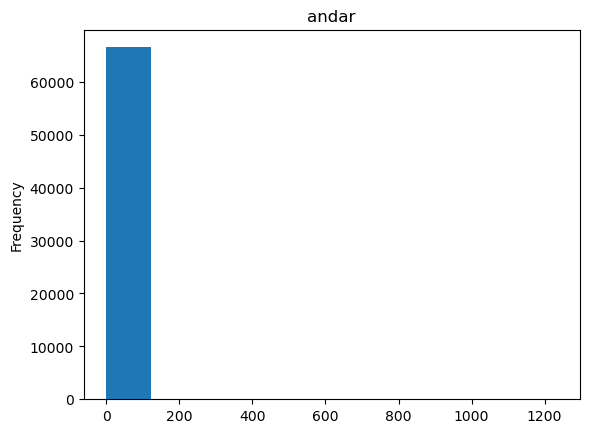

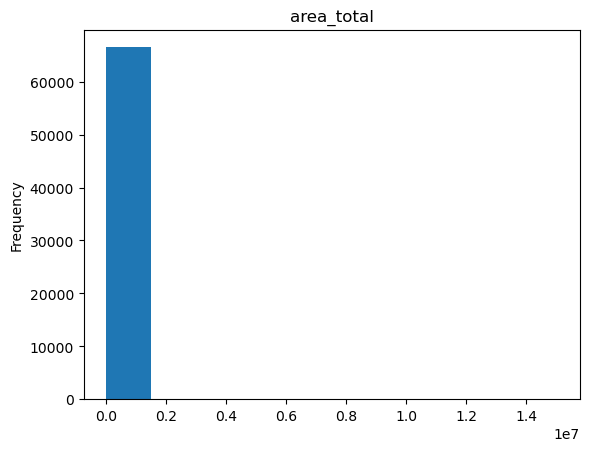

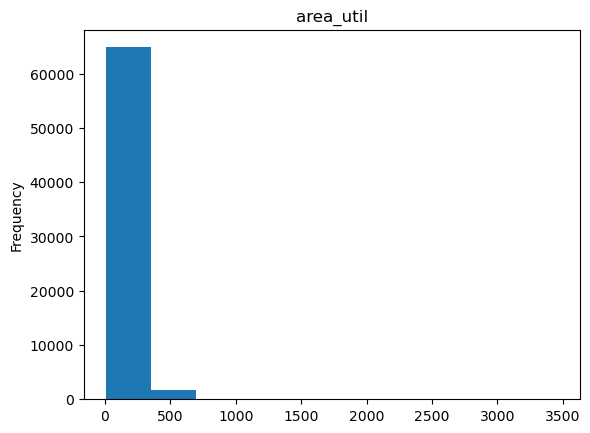

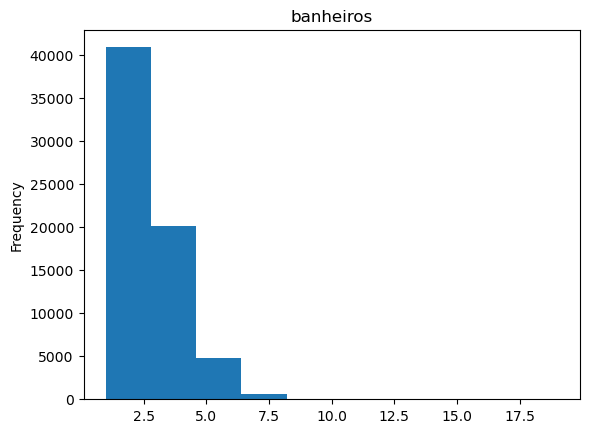

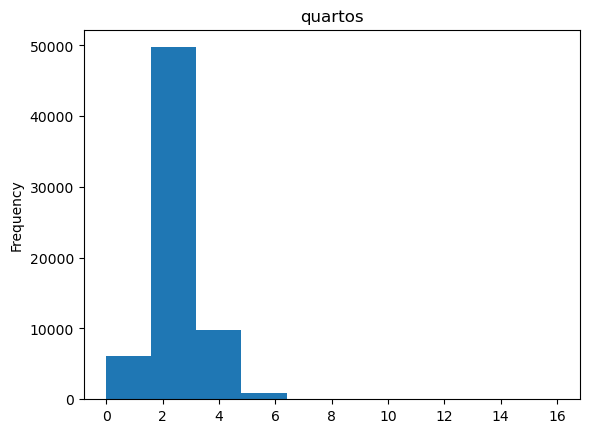

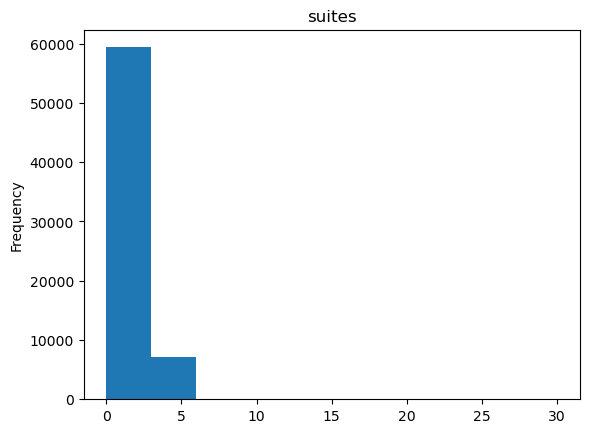

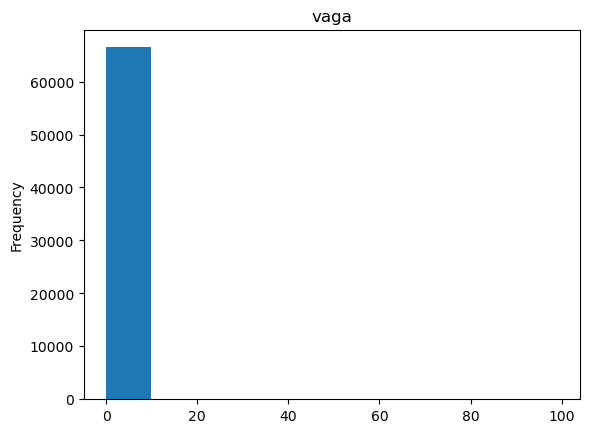

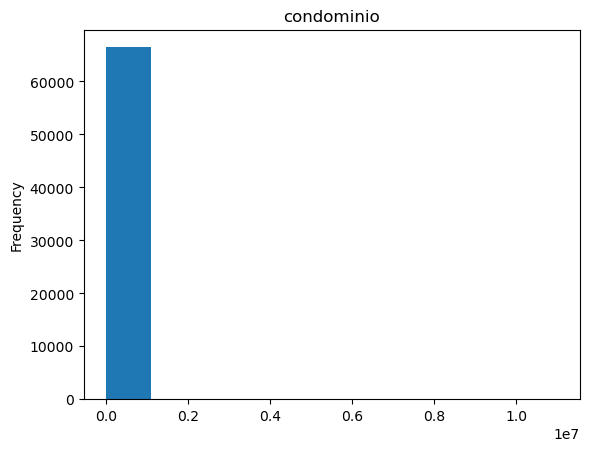

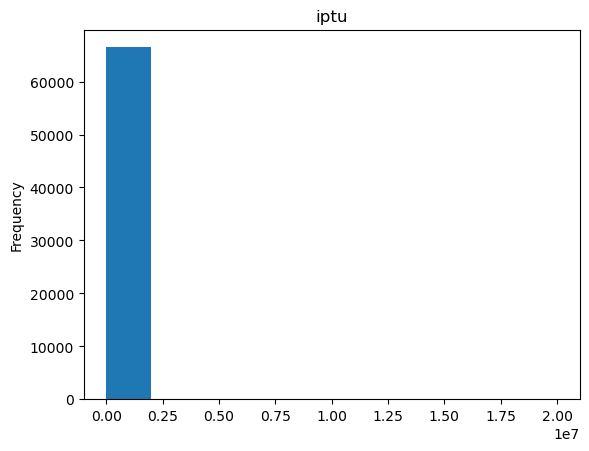

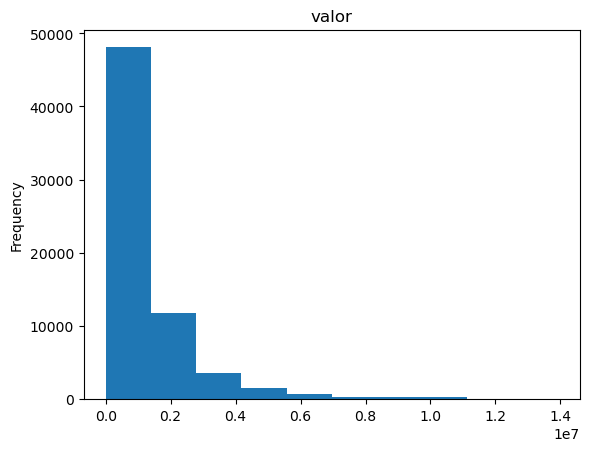

In [109]:
for col in ['andar','area_total','area_util','banheiros','quartos','suites','vaga','condominio','iptu','valor']:
    plt.figure()
    plt.title(col)
    df_pd[col].plot(kind='hist') 

<Axes: title={'center': 'zona'}, xlabel='zona'>

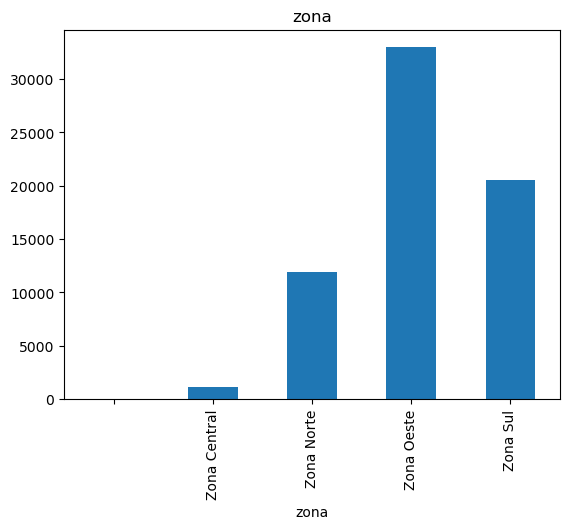

In [118]:
plt.figure()
plt.title('zona')
df_pd.groupby('zona').size().plot(kind='bar')